In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
from tqdm.auto import tqdm

from utils import (
    fit_exp,
)

In [2]:
yahist.utils.set_default_style()

In [3]:
fname = "../sources/1point3acres/data/cases_and_deaths.json.gz"
df_total = pd.read_json(fname)
df_total["date"] = pd.to_datetime(df_total["date"])
df_total = df_total.sort_values(["date"])

# drop cruise ship stuff
df_total = df_total[
    (df_total["state"].str.len() == 2)
    & (df_total["county"].str.strip().str.len() > 0)
]

df_total["place"] = df_total["county"].str.cat(df_total["state"], sep=", ")

df_deaths = df_total.query("is_death").reset_index(drop=True)
df_cases = df_total.query("not is_death").reset_index(drop=True)

# total cases, so no deaths
df_counties = df_cases.groupby(["date","place"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()
df_states = df_cases.groupby(["date","state"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()

In [4]:
df_cases

,date,state,county,gender,age,is_death,ngroup,place
0,2020-01-21,WA,Snohomish,,NaN,False,1,"Snohomish, WA"
1,2020-01-24,IL,Cook,,NaN,False,1,"Cook, IL"
2,2020-01-26,CA,Orange,,NaN,False,1,"Orange, CA"
3,2020-01-26,AZ,Maricopa,,NaN,False,1,"Maricopa, AZ"
4,2020-01-26,CA,Los Angeles,,NaN,False,1,"Los Angeles, CA"
...,...,...,...,...,...,...,...,...
96793,2020-03-27,NY,New York,,NaN,False,2461,"New York, NY"
96794,2020-03-27,NY,New York,,NaN,False,2461,"New York, NY"
96795,2020-03-27,NY,New York,,NaN,False,2461,"New York, NY"
96796,2020-03-27,NY,New York,,NaN,False,2461,"New York, NY"


In [5]:
df_counties.tail()

place,"Abbeville, SC","Acadia, LA","Accomack, VA","Ada, ID","Adair, IA","Adair, MO","Adair, OK","Adams, CO","Adams, IL","Adams, IN",...,"Young, TX","Yuba, CA","Yuma, AZ","Yuma, CO","unassign, MN","​Armstrong, PA","​Carbon, PA","​Clearfield, PA","​Juniata, PA","​Somerset, PA"
date,,,,,,,,,,,,,,,,,,,,,
2020-03-23,1,1,2,20,1,1,0,25,1,1,...,0,3,2,1,0,0,0,0,0,0
2020-03-24,1,2,2,24,1,1,0,27,1,1,...,1,3,2,1,0,1,1,1,1,1
2020-03-25,3,2,2,39,1,1,2,38,1,1,...,1,3,3,1,0,1,1,2,1,2
2020-03-26,4,3,2,54,1,1,2,50,1,1,...,1,3,4,2,1,1,2,2,1,2
2020-03-27,4,8,2,54,1,1,3,50,1,1,...,1,3,4,2,1,1,2,2,1,2


In [6]:
df_states.tail()

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2020-03-23,34,196,189,235,2243,723,415,141,88,1228,...,28,586,812,257,257,75,2154,426,22,28
2020-03-24,43,242,225,326,2631,911,618,187,104,1471,...,30,780,1034,298,304,97,2469,487,39,36
2020-03-25,43,435,301,403,3169,1087,875,231,119,1977,...,41,917,1363,346,398,123,2599,637,49,49
2020-03-26,58,536,349,508,4044,1430,1012,267,143,2483,...,46,1099,1664,402,470,156,3207,728,76,55
2020-03-27,69,571,380,665,4203,1430,1012,271,163,2900,...,58,1178,1749,402,609,184,3213,732,76,70


{'xs': array([ 0.,  1.,  6.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35.]), 'ys': array([  1,   1,   1,   1,   1,   1,   1,   3,   3,   4,   4,   4,   5,
         5,   5,   6,   6,  13,  14,  17,  22,  29,  42,  53,  65,  78,
        95, 125, 152, 187, 256]), 'ypred': array([7.01220546e-02, 8.85533587e-02, 2.84417992e-01, 4.53584157e-01,
       5.72806955e-01, 7.23366992e-01, 9.13501139e-01, 1.15361129e+00,
       1.45683345e+00, 1.83975635e+00, 2.32332901e+00, 2.93400683e+00,
       3.70519890e+00, 4.67909574e+00, 5.90897751e+00, 7.46212883e+00,
       9.42351982e+00, 1.19004547e+01, 1.50284420e+01, 1.89786084e+01,
       2.39670604e+01, 3.02667072e+01, 3.82221913e+01, 4.82687427e+01,
       6.09559905e+01, 7.69780310e+01, 9.72114013e+01, 1.22763033e+02,
       1.55030809e+02, 1.95780043e+02, 2.47240052e+02]), 'pars': array([0.11751747, 0.23336793, 2.21259895]), 'cov': array([[

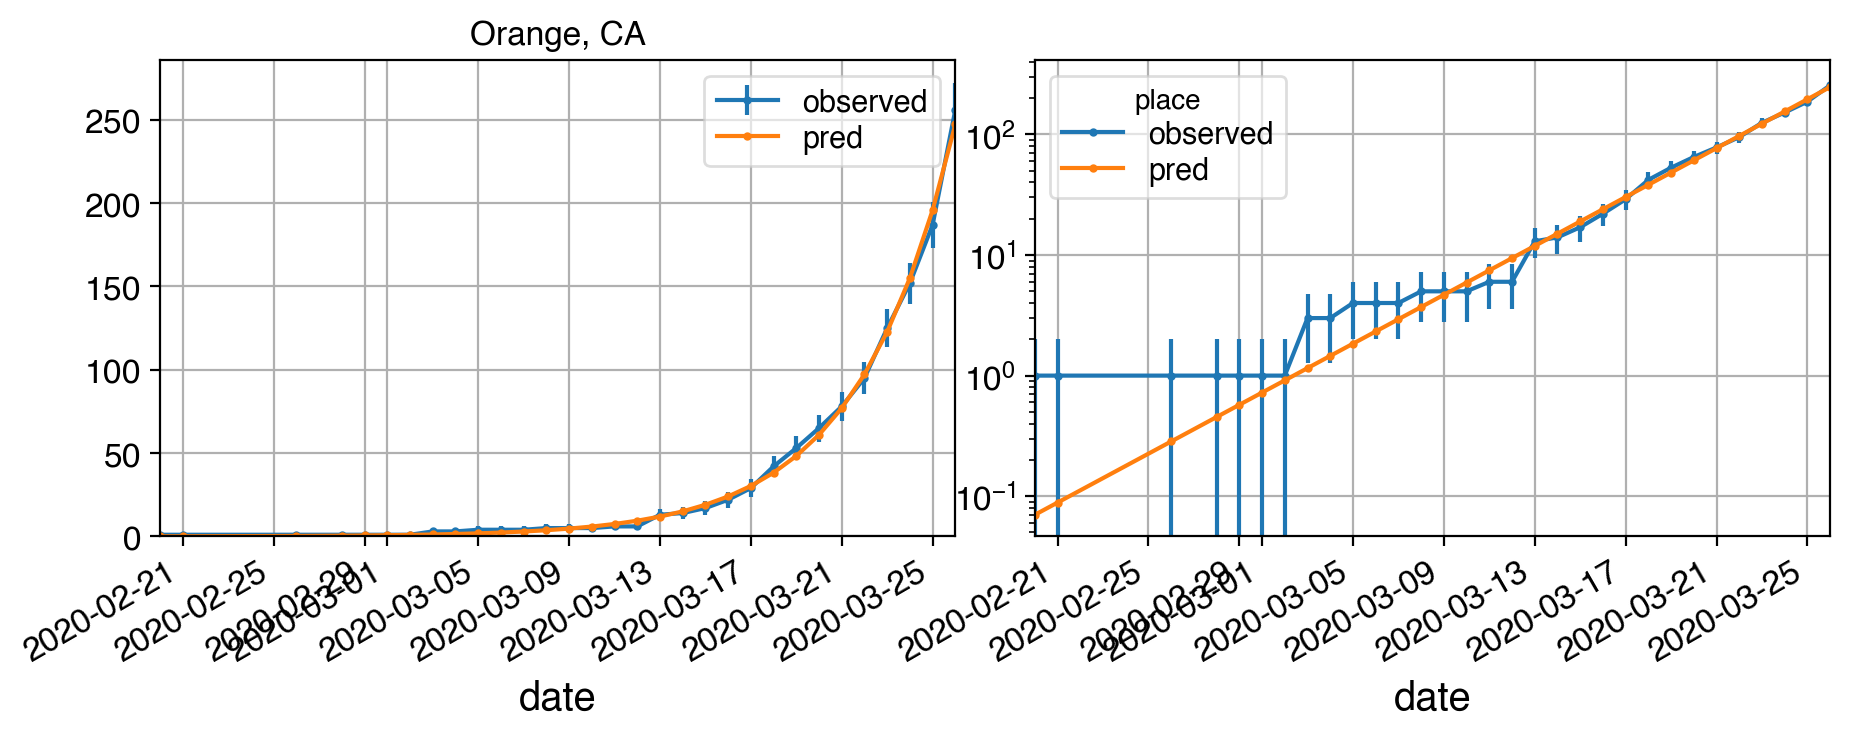

In [20]:
# OK, I cheated a little bit. I fitted each county and looked at which ones had the best
# fit chi2 ;). Why else would I have...DeKalb, GA?

# c = "Los Angeles, CA"
# c = "Cook, IL"
# c = "New York, NY"
# c = "DeKalb, GA"
c = "Orange, CA"
df = df_counties[[c]]

df = df.loc["2020-02-20":"2020-03-26"]

# c = "NY"
# df = df_states[[c]]

df = df.rename({c: "observed"},axis=1).copy()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3.5))

ret = fit_exp(df["observed"])
print(ret)
if ret:
    print("doubling time (days):", ret["td"])
    df["pred"] = ret["ypred"]
    

df.plot(ax=ax1, logy=False,marker="o",grid=True, ms=2, yerr=dict(observed=df["observed"]**0.5))
df.plot(ax=ax2, logy=True,marker="o",grid=True, ms=2, yerr=dict(observed=df["observed"]**0.5))
ax1.legend();
ax1.set_ylim(bottom=0.)
ax1.set_title(c);

In [8]:
df_counties.max().sort_values()

place
Cleburne, AL           1
Meade, SD              1
Meagher, MT            1
Mecosta, MI            1
Meigs, TN              1
                   ...  
Suffolk, NY         3385
Unassigned, NJ      3427
Nassau, NY          4657
Westchester, NY     7187
New York, NY       25573
Length: 1728, dtype: int64

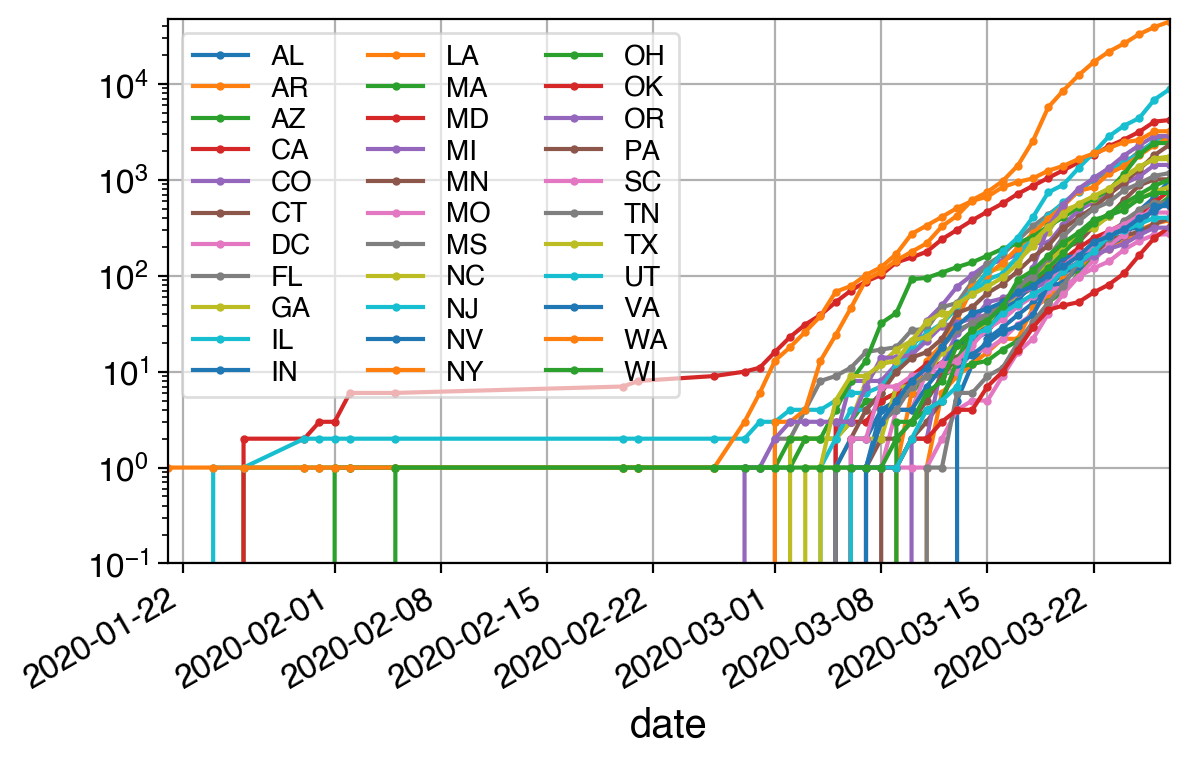

In [21]:
fig, ax = plt.subplots()

# states with > cases now
x = df_states.max().gt(250)
x = x[x].index
df_states[x].plot(ax=ax, legend=False, markersize=2.0, marker="o")

ax.legend(ncol=3, fontsize=10)
ax.grid()
ax.set_ylim(bottom=0)

ax.set_ylim(bottom=0.1)
ax.set_yscale("log")

In [10]:
def calc_tds(df):
    # fixme. throw away the last day to fix fits
    df = df.loc["2020-02-20":"2020-03-26"]
    data = []
    for region in tqdm(df.columns):
        vals = df[region]
        ret = fit_exp(vals)
        if not ret: continue
        td = ret["td"]
        data.append(dict(region=region, td=td, cases=vals.max()))
    return pd.DataFrame(data)

dfr_states = calc_tds(df_states)
dfr_counties = calc_tds(df_counties)

/Users/namin/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


477
53


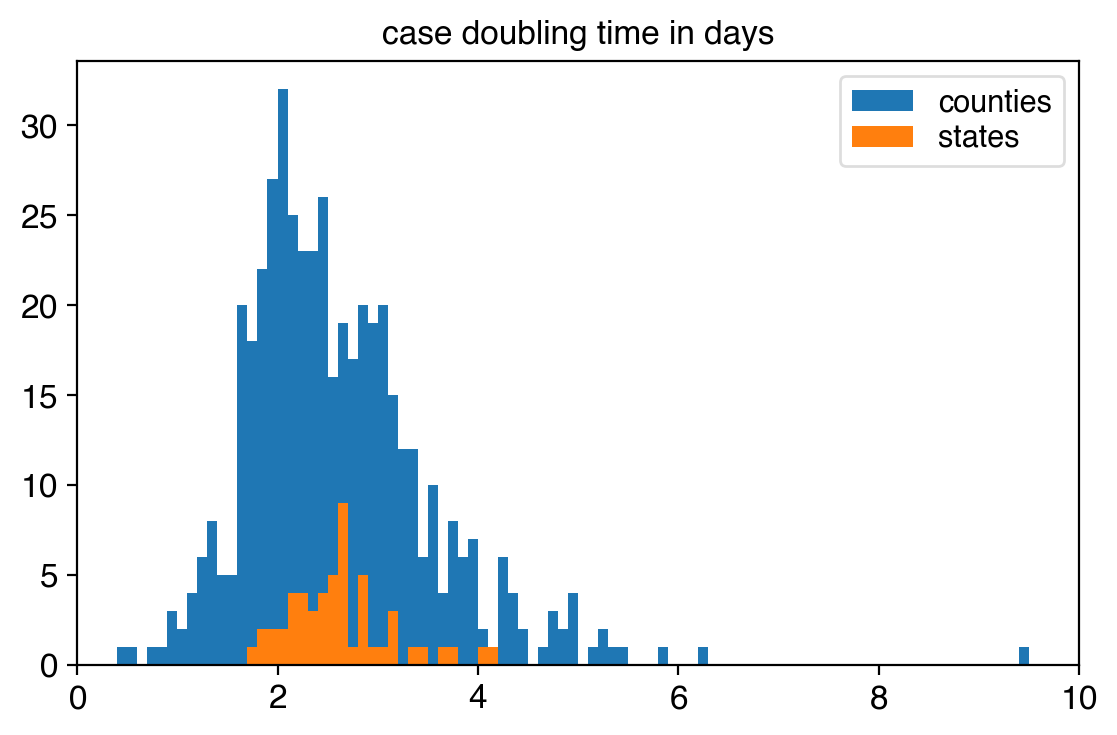

In [26]:
fig, ax = plt.subplots()
Hist1D(dfr_counties.query("cases>10")["td"], bins="100,0,10").plot(ax=ax, label="counties")
Hist1D(dfr_states["td"], bins="100,0,10").plot(ax=ax, label="states")
ax.legend()
ax.set_title("case doubling time in days")

print(len(dfr_counties.query("cases>10")))
print(len(dfr_states))

Text(0.5, 0, 'days after total cases exceed 100')

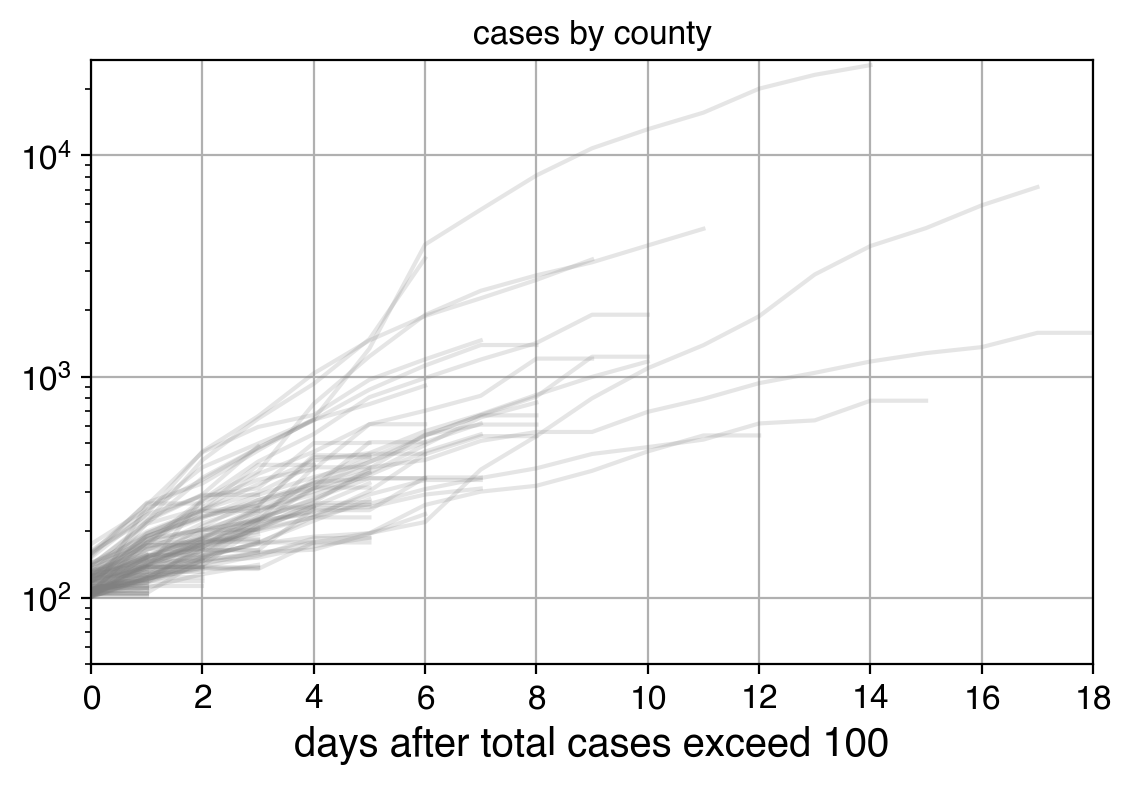

In [27]:
fig, ax = plt.subplots()

thresh=100

firstdt = df.index.min()

for i,county in enumerate(tqdm(df_counties.columns)):

    vals = df_counties[county]
    ys = vals.values
    xs = (vals.index-vals.index.min()).days.values
    try:
        ifirst = np.where(ys>thresh)[0][0]
    except:
        continue
    xs = xs[ifirst:]-xs[ifirst]
    ys = ys[ifirst:]
    ax.plot(xs, ys, label=county, color="gray", alpha=0.2)
    

ax.grid()
ax.set_ylim(bottom=thresh*0.5)
ax.set_yscale("log")
ax.set_title("cases by county")
ax.set_xlabel(f"days after total cases exceed {thresh}")